In [1]:
#Import all the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error as MSE

In [2]:
#Import the dataset
nflx = pd.read_csv("D:/datacamp/Python/Machine Learning for Finance in Python/NFLX.csv")

In [3]:
#Inspect the columns of the dataset
print(nflx.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB
None


In [4]:
#The 'Date' column needs to converted into datetime type
nflx["Date"] = pd.to_datetime(nflx["Date"])
print(nflx.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1259 non-null   datetime64[ns]
 1   Open       1259 non-null   float64       
 2   High       1259 non-null   float64       
 3   Low        1259 non-null   float64       
 4   Close      1259 non-null   float64       
 5   Adj Close  1259 non-null   float64       
 6   Volume     1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB
None


In [5]:
#Make the 'Date' column into the index of the dataset and remove the original 'Date' column
nflx.index = nflx["Date"]
nflx = nflx.drop("Date", axis=1)
print(nflx)
print(nflx.info())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-09-28  101.570000  103.330002   97.839996   99.470001   99.470001   
2015-09-29   99.629997  100.629997   96.849998   98.349998   98.349998   
2015-09-30   99.910004  103.459999   99.050003  103.260002  103.260002   
2015-10-01  102.910004  106.110001  101.120003  105.980003  105.980003   
2015-10-02  103.010002  106.870003  101.449997  106.110001  106.110001   
...                ...         ...         ...         ...         ...   
2020-09-21  467.690002  487.779999  466.320007  487.350006  487.350006   
2020-09-22  489.010010  491.820007  479.260010  491.170013  491.170013   
2020-09-23  491.040009  491.040009  469.000000  470.609985  470.609985   
2020-09-24  470.529999  477.000000  467.820007  473.079987  473.079987   
2020-09-25  474.390015  484.869995  468.029999  482.880005  482.880005   

              Volume  
Date          

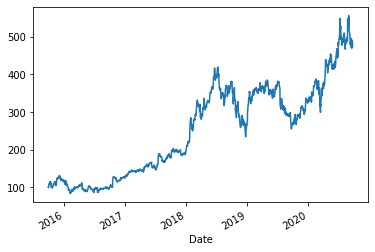

In [6]:
#Create a plot of Netflix's stock trend
nflx["Adj Close"].plot()
plt.show()

C:\Users\ASUS\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


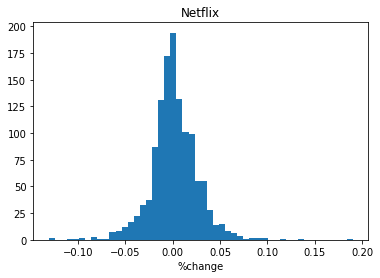

In [7]:
#Create a new column for the %change of the adjusted closing stock price
nflx['Pct Change'] = nflx["Adj Close"].pct_change()

#Create a histogram of the %changes
plt.hist(nflx['Pct Change'], bins=50)
plt.title('Netflix')
plt.xlabel('%change')
plt.show()

In [8]:
#Create columns for the adjusted closing stock price 1 day in the future, %change of the price for 1 day in the future.
#%change of volume and 5 days moving average of %change of volume
nflx['Future Close'] = nflx['Adj Close'].shift(-1)
nflx['Future Close Pct'] = nflx['Future Close'].pct_change(1)
nflx['Volume Pct Change'] = nflx['Volume'].pct_change(1)
nflx['Volume Pct Change 5dMA'] = nflx['Volume Pct Change'].rolling(5, min_periods=1).mean()
print(nflx)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-09-28  101.570000  103.330002   97.839996   99.470001   99.470001   
2015-09-29   99.629997  100.629997   96.849998   98.349998   98.349998   
2015-09-30   99.910004  103.459999   99.050003  103.260002  103.260002   
2015-10-01  102.910004  106.110001  101.120003  105.980003  105.980003   
2015-10-02  103.010002  106.870003  101.449997  106.110001  106.110001   
...                ...         ...         ...         ...         ...   
2020-09-21  467.690002  487.779999  466.320007  487.350006  487.350006   
2020-09-22  489.010010  491.820007  479.260010  491.170013  491.170013   
2020-09-23  491.040009  491.040009  469.000000  470.609985  470.609985   
2020-09-24  470.529999  477.000000  467.820007  473.079987  473.079987   
2020-09-25  474.390015  484.869995  468.029999  482.880005  482.880005   

              Volume  Pct Change  Fut

In [9]:
#We are about to add more features to make better predictions. 
#We will use two indicators as features : Moving Average (MA) and Relative Strength Index (RSI)
#Moving average is the average of previous data points. We will use the available function for moving average from pandas
#RSI is defined as : RSI = 100 - 100/(1+rs), rs = average gain over n periods/average loss over n periods

#Initiate a list of feature names
nflx_feature_names = ['Future Close Pct', 'Volume Pct Change', 'Volume Pct Change 5dMA']

#Define a function for calculating RSI
def computersi(data, time):
    diff = data.diff(1).dropna()
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    up_chg[diff>0] = diff[diff > 0]
    down_chg[diff<0] = diff[diff < 0]
    up_chg_avg = up_chg.ewm(com = time-1,min_periods = time).mean()
    down_chg_avg = down_chg.ewm(com = time-1, min_periods = time).mean()
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100-100/(1+rs)
    return rsi

#Create moving averages and rsi for timeperiods of 14, 30, 50, 200
for n in [14,30,50,200]:
    nflx['ma '+str(n)] = nflx['Adj Close'].rolling(n, min_periods = 1).mean()
    nflx['rsi '+str(n)] = computersi(nflx['Adj Close'],n)
    #Add moving average and rsi to the feature list
    nflx_feature_names += ['ma '+str(n), 'rsi '+str(n)]
print(nflx_feature_names)

['Future Close Pct', 'Volume Pct Change', 'Volume Pct Change 5dMA', 'ma 14', 'rsi 14', 'ma 30', 'rsi 30', 'ma 50', 'rsi 50', 'ma 200', 'rsi 200']


In [10]:
#Remove all na values
nflx = nflx.dropna()

#Create features and targets
#Use variable nflx_feature_names as feature and 'Pct Change' column of nflx dataset as target
nflx_X = nflx[nflx_feature_names]
nflx_y = nflx['Pct Change']

#Create a dataframe from the target and feature columns
nflx_Xy_cols = ['Pct Change'] + list(nflx_X)
nflx_new = nflx[nflx_Xy_cols]
print(nflx_new.head())
print(nflx_new.tail())

            Pct Change  Future Close Pct  Volume Pct Change  \
Date                                                          
2016-07-14    0.016489          0.003775           0.127279   
2016-07-15    0.003775          0.004269          -0.085291   
2016-07-18    0.004269         -0.131262           2.170761   
2016-07-19   -0.131262          0.024115           0.942162   
2016-07-20    0.024115         -0.021841          -0.577504   

            Volume Pct Change 5dMA      ma 14     rsi 14      ma 30  \
Date                                                                  
2016-07-14                0.038141  93.622143  57.257072  94.649667   
2016-07-15                0.052920  94.332857  57.935492  94.554333   
2016-07-18                0.368522  95.295714  58.736125  94.528333   
2016-07-19                0.581944  95.143570  35.968542  94.031666   
2016-07-20                0.515481  94.918571  39.968086  93.632333   

               rsi 30    ma 50     rsi 50     ma 200    rsi 

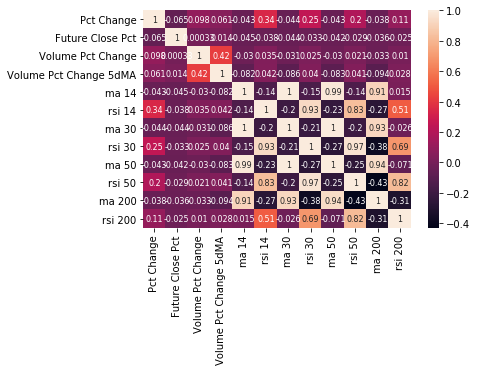

In [11]:
#Create a heatmap of the calculated correlation matrix
sns.heatmap(nflx_new.corr(),annot=True,annot_kws={"size":8})
plt.xticks(rotation=90, size=10)
plt.yticks(size=10)
plt.show()

In [97]:
#Split the new dataset into 80% train set and 20% test set
train_size = int(0.8*nflx_X.shape[0])
X_train = nflx_X[:train_size]
X_test = nflx_X[train_size:]
y_train = nflx_y[:train_size]
y_test = nflx_y[train_size:]
print(X_train.shape, X_test.shape)

(846, 11) (212, 11)


In [98]:
#We are about to apply tree-based machine learning regression models : Decision Tree, Random Forest and Gradient Boosting
#to predict the stock price of Netflix
#Define a function to create the model, fit to the training data and check the R^2 score and RMSE  
def choose_model(model):
    regressor = model
    y_pred_train = regressor.fit(X_train, y_train).predict(X_train)
    y_pred_test = regressor.fit(X_train, y_train).predict(X_test)
    r2_train = regressor.score(X_train, y_train)
    r2_test = regressor.score(X_test, y_test)
    rmse_train = MSE(y_train, y_pred_train)**1/2
    rmse_test = MSE(y_test, y_pred_test)**1/2
    return([r2_train, r2_test, rmse_train, rmse_test])

In [99]:
#Create Decision Tree, Random Forest and Gradient Boosting models
decision_tree = DecisionTreeRegressor()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()

#Create a dictionary which contains the model names and their respective created models
model_choice = {"Decision Tree":decision_tree, "Random Forest":random_forest, "Gradient Boosting":gradient_boosting}
#Create an empty list for the model names and scores
model_name = []
accuracy = []

for m in model_choice.keys():
    #Add the model names to the list
    model_name.append(m)
for model in model_choice.values():
    #Add the R^2 scores and RMSE to the list
    accuracy.append(choose_model(model))

#Convert the list of model names into dataframe
model_df = pd.DataFrame(model_name, columns = ['Model'])
#Convert the list of R^2 scores and RMSE into dataframe
accuracy_df = pd.DataFrame(accuracy, columns = ['R^2 Train','R^2 Test','RMSE Train','RMSE Test'])
#Combine the two dataframes
model_accuracy_df = pd.concat([model_df,accuracy_df], axis=1)
print(model_accuracy_df)

               Model  R^2 Train  R^2 Test    RMSE Train  RMSE Test
0      Decision Tree   0.999988 -0.645673  3.339725e-09   0.000694
1      Random Forest   0.882233  0.167356  3.320946e-05   0.000351
2  Gradient Boosting   0.672132  0.126726  9.480857e-05   0.000368


In [100]:
#From the three models, random forest had the highest R^2 score and the lowest RMSE on the test set
#Thus, random forest was the best model for predicting the stock prices.
#Now, let's see if we can optimize the random forest model with hyperparameter tuning

#Create an empty list for R^2 scores
result = []
#Create a hyperparameter dictionary to search
grid = {'max_depth':[4,5,6,7,8],'random_state':[42], 'n_estimators':[100,150,200],'max_features':[4,5,6,7,8,9,10,11]}
#Set the parameter grid and add the R^2 scores to the list
for g in ParameterGrid(grid):
    random_forest.set_params(**g)
    random_forest.fit(X_train, y_train)
    result.append(random_forest.score(X_test, y_test))

#Find the best R^2 scores and hyperparameters 
best_idx=np.argmax(result)
print(result[best_idx],ParameterGrid(grid)[best_idx])

0.19411866074880246 {'random_state': 42, 'n_estimators': 150, 'max_features': 8, 'max_depth': 8}


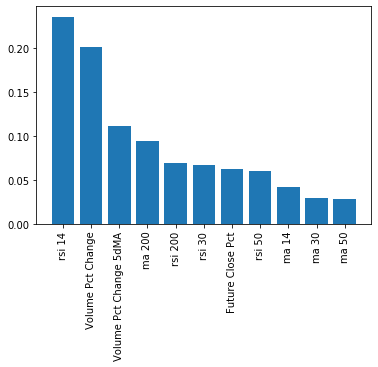

In [102]:
#The best R^2 score occurs when the hyperparameters are set as following :
#random_state = 42, n_estimators = 150, max_features = 8, max_depth = 6
#The R^2 score also improves from the previous Random Forest model

#Now we want to get the importance of the features from the random forest model with the best hyperparameters
#Create the random forest with the best hyperparameters and fit into the training data
rf = RandomForestRegressor(n_estimators = 150, max_depth = 8, max_features = 8, random_state = 42)
rf.fit(X_train, y_train)

#Get the feature importances
feature_importances = rf.feature_importances_

#Get the index of importances from the greatest importance to the least one
sorted_index = np.argsort(feature_importances)[::-1]
x = range(nflx_X.shape[1])

#Create a bar chart to show the importance of the features
labels = np.array(nflx_feature_names)[sorted_index]
plt.bar(x, feature_importances[sorted_index], tick_label = labels)
plt.xticks(rotation=90)
plt.show()

In [103]:
#We are going to create a new dataframe which consists of three columns : Adjusted Close Price, Percent Change and 
#Predicted Percent Change
#First, transform the set of predicted percent change into dataframe and use the index of the target test data (percent change)
y_pred_test_df = pd.DataFrame(y_pred_test, columns = ["Predicted Pct Change"])
y_pred_test_df.index = y_test.index

#Inspect the type of the target test data (percent change)
print(type(y_test))

<class 'pandas.core.series.Series'>


In [69]:
#The target test data is still time series type. Convert it into dataframe type
y_test_df = pd.Series.to_frame(y_test)

#Now, create a column which contains the adjust close price data with the test size 
nflx_test_size = nflx[train_size:]
nflx_adj_close = nflx_test_size["Adj Close"]

#Combine all of the three new columns
nflx_act_pred = pd.concat([nflx_adj_close,y_test_df,y_pred_test_df],axis=1)
print(nflx_act_pred)

             Adj Close  Pct Change  Predicted Pct Change
Date                                                    
2019-11-21  311.690002    0.021399              0.025545
2019-11-22  310.480011   -0.003882              0.003171
2019-11-25  315.549988    0.016329              0.012083
2019-11-26  312.489990   -0.009697              0.002099
2019-11-27  315.929993    0.011008              0.002413
...                ...         ...                   ...
2020-09-18  469.959991   -0.000510             -0.011172
2020-09-21  487.350006    0.037003             -0.005862
2020-09-22  491.170013    0.007838             -0.006272
2020-09-23  470.609985   -0.041859             -0.006541
2020-09-24  473.079987    0.005249             -0.007068

[212 rows x 3 columns]


In [107]:
#Add a new column for predicted adjusted close price : Predicted Adj Close
#For the first row, assume the predicted adjusted close price is the actual price
#For the other rows, calculate the predicted price as the sum of previous predicted price and the absolute predicted change 
for i in range(len(nflx_act_pred)):
    if i == 0:
        nflx_act_pred["Predicted Adj Close"].iloc[i] = nflx_act_pred["Adj Close"].iloc[i]
    else:
        nflx_act_pred["Predicted Adj Close"].iloc[i] = nflx_act_pred["Predicted Adj Close"].iloc[i-1]*(1+nflx_act_pred["Predicted Pct Change"].iloc[i-1])

#Sort the columns into the following order : Adj Close, Pct Change, Predicted Adj Close, Predicted Pct Change
nflx_act_pred = nflx_act_pred[["Adj Close", "Pct Change", "Predicted Adj Close", "Predicted Pct Change"]]
print(nflx_act_pred)

             Adj Close  Pct Change  Predicted Adj Close  Predicted Pct Change
Date                                                                         
2019-11-21  311.690002    0.021399           311.690002              0.025545
2019-11-22  310.480011   -0.003882           319.652017              0.003171
2019-11-25  315.549988    0.016329           320.665677              0.012083
2019-11-26  312.489990   -0.009697           324.540206              0.002099
2019-11-27  315.929993    0.011008           325.221349              0.002413
...                ...         ...                  ...                   ...
2020-09-18  469.959991   -0.000510           433.268445             -0.011172
2020-09-21  487.350006    0.037003           428.427997             -0.005862
2020-09-22  491.170013    0.007838           425.916408             -0.006272
2020-09-23  470.609985   -0.041859           423.245062             -0.006541
2020-09-24  473.079987    0.005249           420.476635         

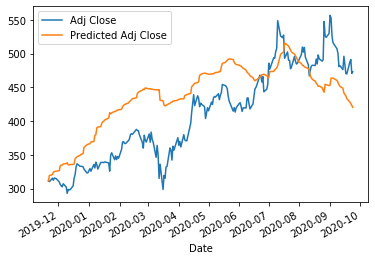

In [89]:
#Plot the actual adjusted close price vs the predicted one
nflx_act_pred["Adj Close"].plot(legend = True)
nflx_act_pred["Predicted Adj Close"].plot(legend = True)
plt.show()

In [106]:
#Seems like our prediction was close enough compared to the actual stock price around June 2020 to August 2020
#Finally, save the dataframe as CSV file
nflx_act_pred.to_csv(r'D:/datacamp/Python/Machine Learning for Finance in Python/NFLX Actual vs Predicted.csv', header = True)

In [104]:
#Conclusion : using the 1 year data as the test set, most of our prediction of Netflix's adjusted closing stock price was far
#from the actual price. Even with the best tree-based machine learning model:random forest, the data was still overfitted,
#though with hyperparameter tuning the model managed to improve.
#This result was due to the very bullish trend on the last 1 year data, while the previous 4 years data, the training set, 
#had the smoother trend.

In [105]:
#For further research, we can probably use the longer period of data, such as 10 years or more, 
#and use more than 1 year data for our test set